tsfresh: a python library to extract features from time series data like mean, variance etc
autogluon.timeseries: is an auto ml tool for automatically building time series forecasting models, 

In [1]:
# !pip install tsfresh "autogluon.timeseries[all]"
# !pip install statsmodels
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm
from autogluon.timeseries import TimeSeriesPredictor
import matplotlib.pyplot as plt

In [11]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
holiday_df = pd.read_csv('holidays_events.csv')
oil_df = pd.read_csv('oil.csv')
transactions_df = pd.read_csv('transactions.csv')
train_df['date'] = pd.to_datetime(train_df['date'])
oil_df['date'] = pd.to_datetime(oil_df['date'])
holiday_df['date'] = pd.to_datetime(holiday_df['date'])
transactions_df['date'] = pd.to_datetime(transactions_df['date'])


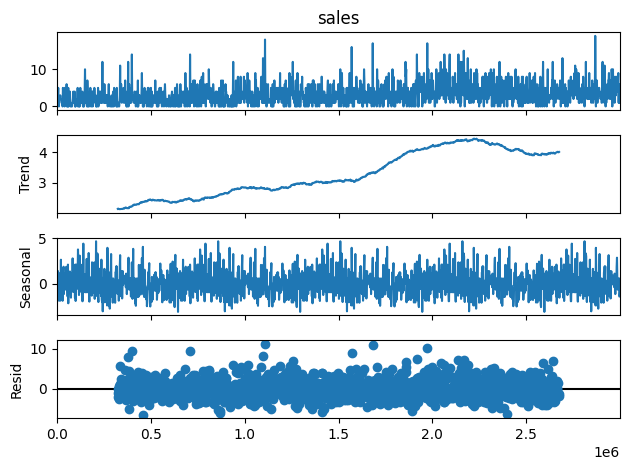

In [14]:
sample = train_df[(train_df['family'] == 'AUTOMOTIVE') & (train_df['store_nbr'] == 1) ]
result = seasonal_decompose(sample['sales'], model = 'additive', period = 365)
result.plot()
plt.show()

### Feature Engineering

In [12]:
## a years lag
train_df['sales_lag_365'] = train_df.groupby('family')['sales'].shift(365)
train_df['sales_lag_365_ratio'] = train_df['sales_lag_365'] / train_df['sales']
## a months lag
train_df['sales_lag_30'] = train_df.groupby('family')['sales'].shift(30)
train_df['sales_lag_30_ratio'] = train_df['sales_lag_30'] / train_df['sales']
train_df['sales_onpromotion'] = train_df['sales'] * train_df['onpromotion']

train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 11 columns):
 #   Column               Dtype         
---  ------               -----         
 0   id                   int64         
 1   date                 datetime64[ns]
 2   store_nbr            int64         
 3   family               object        
 4   sales                float64       
 5   onpromotion          int64         
 6   sales_lag_365        float64       
 7   sales_lag_365_ratio  float64       
 8   sales_lag_30         float64       
 9   sales_lag_30_ratio   float64       
 10  sales_onpromotion    float64       
dtypes: datetime64[ns](1), float64(6), int64(3), object(1)
memory usage: 251.8+ MB


In [13]:

train_df = train_df.merge(oil_df, how = 'left', on = ['date'])
train_df = train_df.merge(holiday_df, how = 'left', on = ['date'])
train_df = train_df.merge(transactions_df, how = 'left', on = ['date','store_nbr'])




In [20]:
train_df.isnull().sum()

store_nbr                    0
family                       0
target                       0
onpromotion                  0
sales_lag_365            12045
sales_lag_365_ratio     653563
sales_lag_30               990
sales_lag_30_ratio      664172
sales_onpromotion            0
dcoilwtico              955152
type                   2551824
locale                 2551824
locale_name            2551824
description            2551824
transferred            2551824
transactions            249117
dtype: int64

In [14]:
train_df.drop(columns = ['id'], inplace = True)
train_df['store_nbr'] = train_df['store_nbr'].astype('str')
train_df['family'] = train_df['family'].astype('str')

In [18]:
## i did this because timeseriespredictor expects the index in the following format 

train_df = train_df.rename(columns = {'date' : 'timestamp' , 'sales':'target'})
train_df['item_id'] = train_df['store_nbr'] + '_' + train_df['family']
train_df.set_index(['item_id', 'timestamp'], inplace = True)


### Modeling

In [21]:
predictor = TimeSeriesPredictor(
    target = 'target',
    path = 'chronos_large',
    eval_metric = 'RMSLE',
    freq = 'D',
    prediction_length = 16
)

predictor.fit(train_df, presets = 'chronos_large',  time_limit=14400)



Beginning AutoGluon training... Time limit = 14400s
AutoGluon will save models to 'chronos_large'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.0
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       2.92 GB / 15.71 GB (18.6%)
Disk Space Avail:   138.89 GB / 454.51 GB (30.6%)
Setting presets to: chronos_large

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSLE,
 'freq': 'D',
 'hyperparameters': {'Chronos': {'batch_size': 8, 'model_path': 'large'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 16,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'time_limit': 14400,
 'verbosity': 2}

train_data with frequency 'None' has been resampled to frequen

In [23]:
predictions = predictor.predict(train_df)
print(predictions)

data with frequency 'None' has been resampled to frequency 'D'.
Model not specified in predict, will default to the model with the best validation score: Chronos[large]


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

                              mean        0.1        0.2        0.3  \
item_id      timestamp                                                
1_AUTOMOTIVE 2017-08-16   5.400846   2.996225   3.803368   4.005154   
             2017-08-17   5.299953   1.987291   2.794438   3.702475   
             2017-08-18   3.902734   0.908040   1.008934   1.987291   
             2017-08-19   3.652030   1.008934   1.008934   1.987291   
             2017-08-20   4.601343   1.987291   1.987291   3.702475   
...                            ...        ...        ...        ...   
9_SEAFOOD    2017-08-27  21.952900  15.449057  16.947459  20.809724   
             2017-08-28  17.709578  11.250940  14.854861  15.255292   
             2017-08-29  12.742884   6.975319  10.850506  11.858051   
             2017-08-30  13.692307   9.300441  10.359649  11.160519   
             2017-08-31  12.090566   5.851518   7.802023   9.494195   

                               0.4        0.5        0.6        0.7  \
item_

### submission

In [27]:
test_df['store_nbr'] = test_df['store_nbr'].astype('str')
test_df['family'] = test_df['family'].astype('str')

In [28]:
test_df = test_df.rename(columns = {'date':'timestamp'})
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
test_df['item_id'] = test_df['store_nbr'] + '_' + test_df['family']


In [29]:
subm = predictions.copy()
subm = subm[['mean']]
subm.head()

mean
item_id      timestamp           
1_AUTOMOTIVE 2017-08-16  5.400846
             2017-08-17  5.299953
             2017-08-18  3.902734
             2017-08-19  3.652030
             2017-08-20  4.601343

In [31]:
subm = subm.reset_index()
original_test = test_df.reset_index()
submis = original_test.merge(subm,how='left', on = ['timestamp', 'item_id'])
submis.head()

,index_x,id,timestamp,store_nbr,family,onpromotion,item_id,index_y,mean
0,0,3000888,2017-08-16,1,AUTOMOTIVE,0,1_AUTOMOTIVE,0,5.400846
1,1,3000889,2017-08-16,1,BABY CARE,0,1_BABY CARE,16,0.000000
2,2,3000890,2017-08-16,1,BEAUTY,2,1_BEAUTY,32,4.850181
3,3,3000891,2017-08-16,1,BEVERAGES,20,1_BEVERAGES,48,2232.562256
4,4,3000892,2017-08-16,1,BOOKS,0,1_BOOKS,64,0.049949


In [32]:
submis = submis.rename(columns = {'mean':'sales'})
submis[['id','sales']].to_csv('submission.csv', index = False)